# GP Homework: Symbolic Regression.

### Goals
In this homework notebook, the goal is to evolve a genetic program that finds, or at least approximates well, an unknown underlying function. I'll give you some 3D data that has some noise added, and you should evolve a genetic program that evaluates an X and Y value to a Z output, and thus evolves better and better approximations over time! 


In [1]:
import numpy as np
import random
import csv


#Use numpy to load all the data into a matrix.
#We have to skip the first row, since it is a header that just names
#each column 'x, y and z'
data_matrix = np.loadtxt('gp_symbolic_regression.csv', skiprows=1, delimiter=',')
print(data_matrix)

[[-10.         -10.           1.33941017]
 [-10.          -9.7979798    1.21291815]
 [-10.          -9.5959596    0.93887979]
 ...
 [ 10.           9.5959596   -0.70368809]
 [ 10.           9.7979798   -0.62849835]
 [ 10.          10.          -0.65843452]]


## The data
I've loaded in the generated data into a numpy matrix. The first column holds the X values, the second holds the Y values, and the third has the Z (output) values. 

The goal of the genetic program you're evolving is to approximate the underlying function that this data was generated from. You should probably create X and Y `variable_node`s and assign fitness based on how close your genetic program evaluates to the loaded in Z values.

### Let's look at how we can slice up this matrix
Using numpy indexing, we can pull out a single column as an array. The `:` in the expression just means "grab everything". Normal numpy indexing would look something like `data_matrix[x,y]` which would mean grab the value at the x row, and y column. So, writing `data_matrix[:,0]` would read as grab all the values in the 0th column. 

In [2]:
#X Values
data_matrix[:,0]

array([-10., -10., -10., ...,  10.,  10.,  10.])

In [3]:
#Y Values
data_matrix[:,1]

array([-10.       ,  -9.7979798,  -9.5959596, ...,   9.5959596,
         9.7979798,  10.       ])

In [4]:
#Z Values
data_matrix[:,2]

array([ 1.33941017,  1.21291815,  0.93887979, ..., -0.70368809,
       -0.62849835, -0.65843452])

## Let's look at the data in a 3D plot. 
If you didn't install Python with the Anaconda package you might need to do a little additional work here, but let me know if you have any issues.

There are other ways of plotting 3D data, and it might be fun to go down a plotting rabbit hole if you were so inclined! 

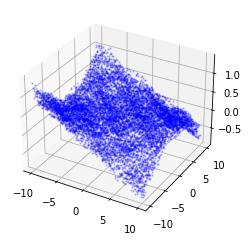

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
    
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection="3d")
#ax = fig.gca(projection='3d')

for row in data_matrix:
    #We'll add a point for each data point in the matrix
    #alpha tells the points to be 20% visible (80% transparent)
    #s is short for size, and we want small since there are so many points!
    ax.scatter(xs=row[0],ys=row[1],zs=row[2], alpha=0.2, color="blue", s=1.6)
plt.show()

## Now let's get on to evolving approximations!
<br>
<br>

# This is the code you've seen before in the GP worksheets. 
You shouldn't need to change any of this, but you might want to implement smarter mutation functions. That part of the code begins at Line 164.

In [182]:
# import gym
# from gym import wrappers
import numpy as np
from matplotlib import pyplot
import random

class GPNode:
    def __init__(self, node_type=None):
        self.parent = None
        self.node_type = node_type
        self.children = []
        self.depth = 0
        
    def add_child(self, child_node):
        child_node.depth = self.depth+1
        self.children.append(child_node)
        child_node.parent = self
    
    
class GPConstNode(GPNode):
    def __init__(self, value=None):
        super().__init__(node_type="Const")
        self.const_value = value
    
    def evaluate(self, input_state):
        return self.const_value
        
    def pretty_print(self, indents=0):
        print('  '*indents + str(self.const_value) 
              + ' : ' + str(self.depth))
        
    def deepcopy(self):
        new_node = GPConstNode(value=self.const_value)
        new_node.depth = self.depth;
        return new_node
        
        
class GPVariableNode(GPNode):
    def __init__(self, variable_name=None):
        super().__init__(node_type="Variable")
        self.variable_name = variable_name
    
    def evaluate(self, input_state):
        return input_state[self.variable_name]
    
    def pretty_print(self, indents=0):
        print('  '*indents + str(self.variable_name)
              + ' : ' + str(self.depth))
        
    def deepcopy(self):
        new_node = GPVariableNode(variable_name = self.variable_name)
        new_node.depth = self.depth
        return new_node
        
class GPFunctionNode(GPNode):
    def __init__(self, arg_count, func_name=None, gp_function=None):
        super().__init__(node_type="Function")
        self.argument_count = arg_count
        self.gp_function = gp_function
        self.function_name = func_name
        
    def evaluate(self, input_state): 
        assert self.argument_count == len(self.children), \
        'Number of child nodes must match argument count'

        child_results = [c.evaluate(input_state) for c in self.children]
        return self.gp_function(*child_results)

    def pretty_print(self, indents=0):
        print('  '*indents + str(self.function_name) 
              + ' : ' + str(self.depth))
        
        for child in self.children:
            child.pretty_print(indents+1)
        
    def deepcopy(self):
        new_node = GPFunctionNode(self.argument_count, 
                                   self.function_name, 
                                   self.gp_function)
        new_node.depth = self.depth
        
        for child in self.children:
            new_node.add_child(child.deepcopy())
        
        return new_node

class GPIndividual:
    # This is the beef of the individual code. We're growing random 
    # trees with a bit of extra sauce. 
    # We've defined a prob_terminal value that determines how 
    # likely it is that we select a terminal when choosing a random GP node. 
    # We're also limiting the depth of the trees we grow, because this is 
    # Python after all. 
    def grow_random(self, cur_node=None, cur_depth=0):
        if (random.random() < self.prob_terminal 
            or cur_depth == self.max_genotype_depth-1):
            new_node = random.choice(self.terminal_set).deepcopy()
            new_node.parent = cur_node
            new_node.depth = cur_depth
        else:
            new_node = random.choice(self.function_set).deepcopy()
            new_node.depth = cur_depth
            new_node.parent = cur_node
            for i in range(new_node.argument_count):
                new_node.add_child(self.grow_random(cur_node=new_node, 
                                                    cur_depth=cur_depth+1))
        return new_node
    
    
    # prob_terminal and max_depth have default parameters but you 
    # can use them to control how big the trees can get and how
    # likely you are to pick function/terminal nodes when growing
    # and mutating trees. 
    def __init__(self, function_set, terminal_set, 
                 prob_terminal=0.2, max_depth=5):
        self.max_genotype_depth = max_depth
        self.fitness = None
        self.function_set = function_set
        self.terminal_set = terminal_set
        self.prob_terminal = prob_terminal
        
        self.genotype = self.grow_random()
        
        
    def pretty_print(self):
        self.genotype.pretty_print()
        
        
    def deepcopy(self):
        new_individual = GPIndividual(self.function_set, 
                                      self.terminal_set, 
                                      self.prob_terminal, 
                                      self.max_genotype_depth)
        new_individual.genotype = self.genotype.deepcopy()
        return new_individual
    
    
    # This function just visits each node in the genome, growing
    # the list of nodes as it encounters children.
    def visit_genotype_nodes(self, cur_node=None):
        if cur_node == None: 
            cur_node = self.genotype
            
        node_list = [cur_node]
        visitor_index = 0
        
        while visitor_index < len(node_list):
            if len(node_list[visitor_index].children) > 0:
                node_list.extend(node_list[visitor_index].children)
            visitor_index += 1
            
        return node_list
        
    
    def evaluate(self, input_state):
        #evaluate the genotype
        return self.genotype.evaluate(input_state)
        
    
    
    #TODO: You might want to implement a more clever mutation function!
    def mutate(self, input_state, target):
        ## visit the constant nodes and try to change the const value
        # get a list of nodes...
        genotype_nodes = self.visit_genotype_nodes()
        constnodeids = [nodeid for nodeid, node in enumerate(genotype_nodes) if isinstance(node, GPConstNode)]
        # and pick a const node, change its value
        if len(constnodeids) > 0:
            random_node = genotype_nodes[random.choice(constnodeids)]

            cur_value = random_node.evaluate(input_state)
            # try to adjust the constant value
            searchrange = np.arange(cur_value-1, cur_value +1, 0.1)
            bestvalue = cur_value
            maxNMSE = np.NINF
            for candidate in searchrange:
                random_node.const_value = candidate
                outcome = self.evaluate(input_state)
                N_MSE = -np.mean((outcome - target) **2) # negative mean square error
                if N_MSE > maxNMSE:
                    bestvalue = candidate
                    maxNMSE = N_MSE
            
            random_node.const_value = bestvalue
            
            # try if it makes sense to change to variable x or y
#             random_node = GPVariableNode(variable_name='x')
#             xrep_val = self.evaluate(input_state)
#             xrep_MSE = -np.mean((xrep_val - target) **2)
            
#             random_node = GPVariableNode(variable_name='y')
#             yrep_val = self.evaluate(input_state)
#             yrep_MSE = -np.mean((yrep_val - target) **2)
            
#             initializers = [lambda: GPConstNode(bestvalue), lambda: GPVariableNode(variable_name='x'),
#                           lambda: GPVariableNode(variable_name='y')]
#             maxchoice = np.argmax([maxNMSE, xrep_MSE, yrep_MSE])
            
#             # final assignment
#             random_node = initializers[maxchoice]()
        
            
class GPPopulation:
    def __init__(self, pop_size, function_set, terminal_set, input_state, target, max_depth, prob_terminal):
        self.pop_size = pop_size
        self.terminal_set = terminal_set
        self.function_set = function_set
        self.input_state = input_state
        self.target = target
        
        self.max_depth = max_depth
        self.prob_terminal = prob_terminal
        
        self.population = [GPIndividual(self.function_set, 
                                        self.terminal_set,
                                        self.prob_terminal, 
                                        self.max_depth) 
                           for _ in range(self.pop_size)]
        
        
    def update_fitnesses(self, fitness_function):
        fitnesses = []
        for individual in self.population:
            individual.fitness = fitness_function(individual)
            fitnesses.append(individual.fitness)
            
        return fitnesses
    
    
    def do_timestep(self, fitness_function, selection_function, mutation_prob):
        fitness_list = self.update_fitnesses(fitness_function)
        selected_individuals = [selection_function(self.population) 
                                for _ in range(self.pop_size)]
        
        for individual_idx in range(len(selected_individuals)):
            individual = selected_individuals[individual_idx].deepcopy()
            
            if random.random() < mutation_prob:
                individual.mutate(self.input_state, self.target)
            
            selected_individuals[individual_idx] = individual
        
        self.population = selected_individuals
        
        return fitness_list


## You'll want to add some more function nodes, and terminal nodes here


In [183]:
gp_add = GPFunctionNode(arg_count=2, func_name="Add", gp_function=lambda w, z: w+z)
gp_sub = GPFunctionNode(arg_count=2, func_name="Sub", gp_function=lambda w, z: w-z)
gp_mul = GPFunctionNode(arg_count=2, func_name="Mul", gp_function=lambda w, z: w*z)
gp_square = GPFunctionNode(arg_count=1, func_name="Square", gp_function=lambda w : w**2)


gp_const1 = GPConstNode(-0.1)

gp_var1 = GPVariableNode(variable_name='x')
gp_var2 = GPVariableNode(variable_name='y')

gp_func_set = [gp_add, gp_sub, gp_mul, gp_square]
gp_term_set = [gp_var1, gp_var2, gp_const1]

## This is probably where most of your attention will go. 
You'll need to evaluate your genetic program tree on all (or probably a subset) of the x and y values provided and measure how good of a solution you have to assign fitness. As a point of reference the sum of squares (feel free to Wikipedia that term if it is unfamiliar) of the true solution and the noisy data I've provided is on the order of 500. 

The selection function is also rather simplistic. It just picks the highest fitness individual in the population. You probably should implement something like tournament selection or at least fitness proportional selection. This is a tricky solution to find the right solution to, so digging into some of the more advanced techniques we learned about in class would be worthwhile! 

In [184]:
def evaluate_symbolic_gp(individual):
    x_vals = data_matrix[:,0]
    y_vals = data_matrix[:,1]
    z_vals = data_matrix[:,2]
        
    outcome = individual.evaluate({'x': x_vals, 'y': y_vals})
    allnodes = individual.visit_genotype_nodes()
    varnodeids = [nodeid for nodeid, node in enumerate(allnodes) if isinstance(node, GPVariableNode)]
    
    if len(varnodeids) == 0: # don't allow pure constants
        return np.NINF
    else:
        return -np.mean((outcome - z_vals) **2)


def my_fitness_function(gp_individual):
    return evaluate_symbolic_gp(gp_individual)

def my_selection_function(gp_population):
    # tournament style
    subset_size = np.rint(len(gp_population) / 10).astype(np.int16)
    subset = random.sample(gp_population, k=subset_size)
    #pick individual with good fitness
    weights = np.array([-1/i.fitness for i in subset])
    weights = weights / np.sum(weights)
    winner_index = np.random.choice(np.arange(0, len(weights)), size=1, p=weights)[0]
    return subset[winner_index]

# Once you've implemented the above functions, this code should work!
### I also just picked some random values for the population size, max_depth, etc., but feel free to experiment with those as well. 

In [185]:
mean_fitnesses = []

gp_pop = GPPopulation(pop_size=1500, 
                      function_set=gp_func_set, 
                      terminal_set=gp_term_set,
                      input_state = {'x': data_matrix[:,0], 'y': data_matrix[:,1]},
                      target = data_matrix[:, 2],
                      max_depth=4,
                      prob_terminal=0.3)


In [186]:
for i in range(20):
    fitnesses = gp_pop.do_timestep(fitness_function=my_fitness_function, 
                   selection_function=my_selection_function,
                   mutation_prob=1)
    mean_fitnesses.append(np.mean(fitnesses))

## And to make sure things are progressing, let's plot the mean fitness over time!

If your fitness function isn't working, you'll probably see a flat line.

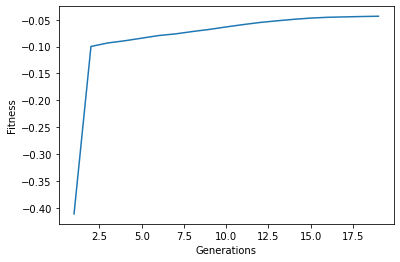

In [191]:
pyplot.plot(mean_fitnesses)
pyplot.xlabel("Generations")
pyplot.ylabel("Fitness")
pyplot.show()

In [192]:
fitnesses = gp_pop.update_fitnesses(my_fitness_function)

In [197]:
gp_pop.population[np.argmax(fitnesses)].pretty_print()

Mul : 0
  Mul : 1
    Add : 2
      0.30000000000000016 : 3
      -2.220446049250313e-16 : 3
    -0.0999999999999992 : 2
  Sub : 1
    Add : 2
      -6.600000000000005 : 3
      y : 3
    Sub : 2
      y : 3
      x : 3


In [199]:
predicted_vals = gp_pop.population[np.argmax(fitnesses)].evaluate({'x': data_matrix[:,0], 'y': data_matrix[:, 1]})

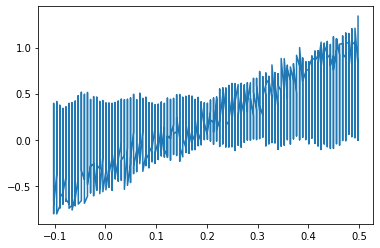

In [200]:
pyplot.plot(predicted_vals, data_matrix[:, 2])